# Restrict data regionally

Maybe you're just interested in a particular region of the Arctic. Here, we want to filter our dataset to only include data from that region. We can do this using the NSIDC region mask for the Arctic, which is included in the NETCDF file available in the jupyter bucket. The function used in this notebook relies on the NSIDC region mask for the arctic included in the NETCDF from the jupyter book's google bucket, where the function is also available as part of the utils.py script. 
 
**Input**:
 - NETCDF4 file from the jupyter book's google bucket
 
 
 **Output**: 
  - Plots of sea ice thickness and sea ice type in the Arctic

```{note}
Try running this notebook in Google Colab! Toggle over the rocketship icon at the top of the page and click Colab to open a new window and run the notebook. <br><br>To run a single cell, type **Shift+Enter** or under **Runtime** click **Run all**. Note that you will have to run the notebook from the very beginning and load all the Google Colab dependencies for the code to work.
```

In [1]:
#this cell will load dependencies for running the notebook in Google Colab
#this cell may take a while to run
import sys

#if code is running in google colab, run these cells to install neccessary libraries
if 'google.colab' in sys.modules: 
    !apt-get install -qq libgdal-dev libproj-dev
    !pip install --no-binary shapely shapely --force
    !pip install -q pyproj
    !pip install cartopy
    !pip install netcdf4
    !pip install xarray==0.16.0 

## Import notebook dependencies

In [2]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import scipy.interpolate
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
from datetime import date
import matplotlib.pyplot as plt
import numpy.ma as ma

#axes needed for plotting
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

# Ignore warnings in the notebook to improve display
# You might want to remove this when debugging/writing new code
import warnings
warnings.filterwarnings('ignore')
 
#increase resolution for notebook outputs
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' 

#import utils function from google bucket 
!gsutil cp gs://icesat2-book-data/utils.py ./
import utils

Copying gs://icesat2-book-data/utils.py...
/ [1 files][ 14.5 KiB/ 14.5 KiB]                                                
Operation completed over 1 objects/14.5 KiB.                                     


## Load data into notebook
Copy file from the book's google bucket and load into an xarray dataset. 

In [3]:
!gsutil -m cp gs://icesat2-book-data/icesat2-book-dataset.nc ./
dataset = xr.open_dataset('icesat2-book-dataset.nc')

Copying gs://icesat2-book-data/icesat2-book-dataset.nc...
- [1/1 files][138.4 MiB/138.4 MiB] 100% Done                                    
Operation completed over 1 objects/138.4 MiB.                                    


## Display region labels and keys 
 - Each region defined by the NSIDC region mask corresponds to a integer key that can be used to reference it.
 - The keys and labels are stored as attributes to the <span style="color:darkmagenta; font-family: Courier">region_mask</span> coordinate value in the NETCDF4 file.
 - The code below creates a pandas DataFrame object to show all of the keys and their corresponding labels

In [4]:
#get region mask attributes as a dictionary object 
regionMask = dataset.region_mask.attrs

#get region keys and labels
keys = regionMask['keys']
labels = regionMask['labels']

#create and display table of keys and labels 
tbl = pd.DataFrame({'key':keys, 'label':labels})
display(tbl.style.hide_index())

key,label
1,non-region oceans
2,Sea of Okhotsk and Japan
3,Bering Sea
4,Hudson Bay
5,Gulf of St. Lawrence
6,"Baffin Bay, Davis Strait & Labrador Sea"
7,Greenland Sea
8,Barents Seas
9,Kara Sea
10,Laptev Sea


## Define region/s of interest by key
 - Define variable <span style="color:darkmagenta; font-family: Courier">regionKeyList</span>, a list of integers corresponding to keys you want to restrict the data to. 
     - Make sure <span style="color:darkmagenta; font-family: Courier">regionKeyList</span> is a list, even if you just want one region (i.e. <span style="color:darkmagenta; font-family: Courier">regionKeyList = [15]</span> for the Arctic Ocean) 

In [5]:
regionKeyList = [10,11,12,13,15] #Inner Arctic
#regionKeyList = [13] #Beaufort Sea
#regionKeyList = [10] #Laptev Sea
#regionKeyList = list(tbl['key']) #if you want to keep all regions

## Restrict the data to desired region/s
This function can also be accessed from the utils.py file, stored in the google bucket for this book. 
 - Function will return a new dataset restricted to the input keys by applying a condition that the region mask needs to be equal to the key/s. 
 - The code will raise a ValueError if <span style="color:darkmagenta; font-family: Courier">regionKeyList</span> is not a list 
 - The code will raise a ValueError if <span style="color:darkmagenta; font-family: Courier">regionKeyList</span> contains invalid keys 
     - Invalid keys are integer values that do not correspond to a region as defined by the NSIDC region mask for the arctic
 - The code will raise a warning if you remove all regions from the data 
     - This occurs when <span style="color:darkmagenta; font-family: Courier">regionKeyList</span> equals an empty list (<span style="color:darkmagenta; font-family: Courier">regionKeyList = []</span>) 

In [6]:
def restrictRegionally(dataset, regionKeyList): 
    """Restrict dataset to input regions.
    
    Args: 
        dataset (xr Dataset): dataset generated by Load_IS2 notebook
        regionKeyList (list): list of region keys to restrict data to 
        
    Returns: 
        regionalDataset (xr Dataset): dataset with restricted data to input regions
    """
    
    def checkKeys(regionKeyList, regionTbl): 
        """Check that regionKeyList was defined correctly

        Raises: 
            ValueError if regionKeyList was not defined correctly 
            warning if all data was removed from the dataset
        """
        if type(regionKeyList) != list: #raise a ValueError if regionKeyList is not a list 
            raise ValueError('regionKeyList needs to be a list. \nFor example, if you want to restrict data to the Beaufort Sea, define regionKeyList = [13]')

        for key in regionKeyList: 
            if key not in list(regionTbl['key']): 
                raise ValueError('Region key ' + str(key) + ' does not exist in region mask. \n Redefine regionKeyList with key numbers from table')

        if len(regionKeyList) == 0: 
            warnings.warn('You removed all the data from the dataset. Are you sure you wanted to do this? \n If not, make sure the list regionKeyList is not empty and try again. \n If you intended to keep data from all regions, set regionKeyList = list(tbl[\"key\"])')
 
    #create a table of keys and labels
    regionMask = dataset.region_mask.attrs
    regionTbl = pd.DataFrame({'key': regionMask['keys'], 'label': regionMask['labels']})
    
    #call function to check if regionKeyList was defined correctly
    checkKeys(regionKeyList, regionTbl)
    
    #keys to remove (all keys that are note listed in regionKeyList)
    keysToRemove = [key for key in list(regionTbl['key']) if key not in regionKeyList]
    
    #filter elements from the ice thickness DataArray where the region is the desired region
    regionalDataset = dataset.copy()
    for var in dataset.data_vars: 
        if var != 'seaice_conc_monthly_cdr':
            regionalVar = regionalDataset[var]
            for key in keysToRemove: 
                regionalVar = regionalVar.where(regionalVar['region_mask'] != key)
            regionalDataset[var] = regionalVar
    
    #find name of labels 
    labels = [regionTbl[regionTbl['key'] == key]['label'].item() for key in regionKeyList]
    
    #add new attributes describing changes made to the dataset
    if len(labels) < len(regionTbl['key']): 
        if set(regionKeyList) == set([10,11,12,13,15]): #convert to sets so unordered lists are compared
            regionalDataset.attrs['regions with data'] = 'Inner Arctic'
        else:    
            regionalDataset.attrs['regions with data'] = ('%s' % ', '.join(map(str, labels)))
        print('Regions selected: ' + regionalDataset.attrs['regions with data'])
    else: 
        regionalDataset.attrs['regions with data'] = 'All'
        print('Regions selected: All \nNo regions will be removed')
    
    return regionalDataset

## Call function to restrict the data regionally

In [7]:
#define a list of keys corresponding to the region of interest
regionKeyList = [10,11,12,13,15] #Inner Arctic

#restrict data to that region
dataset = restrictRegionally(dataset, regionKeyList)

Regions selected: Inner Arctic


## Check that data was restricted to the correct regions
Display a map of the region the data has been restricted to using the plotting function <span style="color:darkmagenta; font-family: Courier">plotOneMonth</span>, defined in the previous mapping notebook. 

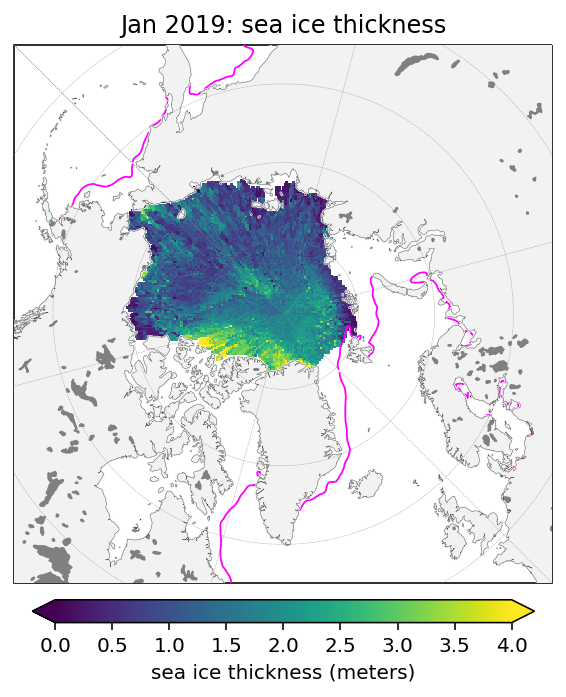

In [8]:
utils.plotOneMonth(dataset, dataVar = 'ice_thickness_filled', month = 'Jan 2019', minval = 0, maxval = 4)